<a href="https://colab.research.google.com/github/GrzegorzMeller/AlgorithmsForMassiveData/blob/master/OCULAR_DISEASE_RECOGNITION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/amd/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /amd/


In [0]:
!cp /amd/My\ Drive/ODIR-5K_aug.zip /content/

In [0]:
!unzip ODIR-5K.zip

In [0]:
import tensorflow as tf
import pandas as pd
import os
from PIL import Image
import matplotlib.pyplot as plt
import IPython.display as display
import numpy as np
import glob
import random

BATCH_SIZE = 32
IMG_HEIGHT = 250
IMG_WIDTH = 250
CLASS_NAMES = ['N', 'D', 'G', 'C', 'A', 'H', 'M', 'O']

In [26]:
train_N_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*N.jpg").repeat()
train_D_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*D.jpg").repeat()
train_G_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*G.jpg").repeat()
train_C_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*C.jpg").repeat()
train_A_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*A.jpg").repeat()
train_H_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*H.jpg").repeat()
train_M_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*M.jpg").repeat()
train_O_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*O.jpg").repeat()
train_MIX_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*X.jpg").repeat() #X = MIX
#test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

for f in train_H_ds.take(15):
  print(f.numpy())

b'ODIR-5K/Validation_Images/849_left-H.jpg'
b'ODIR-5K/Validation_Images/4562_right-H.jpg'
b'ODIR-5K/Validation_Images/374_right-H.jpg'
b'ODIR-5K/Validation_Images/32_left-H.jpg'
b'ODIR-5K/Validation_Images/1989_right-H.jpg'
b'ODIR-5K/Validation_Images/4207_right-H.jpg'
b'ODIR-5K/Validation_Images/116_right-H.jpg'
b'ODIR-5K/Validation_Images/4592_right-H.jpg'
b'ODIR-5K/Validation_Images/2048_left-H.jpg'
b'ODIR-5K/Validation_Images/686_right-H.jpg'
b'ODIR-5K/Validation_Images/723_left-H.jpg'
b'ODIR-5K/Validation_Images/968_right-H.jpg'
b'ODIR-5K/Validation_Images/1377_left-H.jpg'
b'ODIR-5K/Validation_Images/571_left-H.jpg'
b'ODIR-5K/Validation_Images/4581_left-H.jpg'


In [0]:
resampled1_ds =  tf.data.Dataset.list_files("ODIR-5K/Training Images/*.jpg")
test_ds = tf.data.Dataset.list_files("ODIR-5K/Validation_Images/*.jpg")

In [0]:
def get_label(name):
  parts = tf.strings.split(name, sep="-")
  label = tf.strings.split(parts[-1], sep=".")
  label = tf.strings.bytes_split(label[0])
  l = [0, 0, 0, 0, 0, 0, 0, 0]

  for e in label:
    if e != '&' and e != 'X':
      if e == 'N':
        l[0] = 1
      elif e == 'D':
        l[1] = 1
      elif e == 'G':
        l[2] = 1
      elif e == 'C':
        l[3] = 1
      elif e == 'A':
        l[4] = 1
      elif e == 'H':
        l[5] = 1
      elif e == 'M':
        l[6] = 1
      elif e == 'O':
        l[7] = 1

  return l

def get_name(file_path):
  parts = tf.strings.split(file_path, os.path.sep)
  return parts[-1]

def decode_img(img):
  img = tf.image.decode_jpeg(img, channels=3)
  #img = tf.image.adjust_contrast(img, 2)
  img = tf.image.convert_image_dtype(img, tf.float32)
  #img = tf.image.resize_with_pad(img, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return img

def process_path(file_path):
  name = get_name(file_path)
  label = get_label(name)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

In [0]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
AUTOTUNE = tf.data.experimental.AUTOTUNE
resampled_named_ds = resampled1_ds.map(process_path, num_parallel_calls=AUTOTUNE)
test_named_ds = test_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [0]:
train_N_ds = train_N_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_D_ds = train_D_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_G_ds = train_G_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_C_ds = train_C_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_A_ds = train_A_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_H_ds = train_H_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_M_ds = train_M_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_O_ds = train_O_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_MIX_ds = train_MIX_ds.map(process_path, num_parallel_calls=AUTOTUNE)

(250, 250, 3)
label:  M [0 0 0 0 0 0 1 0]
(250, 250, 3)
label:  O [0 0 0 0 0 0 0 1]
(250, 250, 3)
label:  C [0 0 0 1 0 0 0 0]
(250, 250, 3)
label:  D [0 1 0 0 0 0 0 1]
(250, 250, 3)
label:  N [1 0 0 0 0 0 0 0]
(250, 250, 3)
label:  D [0 1 0 0 0 0 0 0]


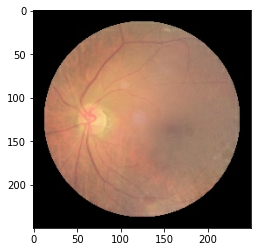

In [12]:
for image, label in resampled_named_ds.take(6):
  print(image.shape)
  plt.imshow(image.numpy())
  print('label: ', CLASS_NAMES[np.nonzero(label.numpy()==1)[0][0]], label.numpy())

In [0]:
def randomly_augment(image,label):
  image = tf.image.random_flip_left_right(image)
  #image = tf.image.central_crop(image, central_fraction=0.9)
  #image = tf.image.resize_with_pad(image, IMG_HEIGHT, IMG_WIDTH, method='bilinear', antialias=False)
  return image, label

def prepare_for_training(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  #ds = ds.cache()
  ds = ds.shuffle(buffer_size=shuffle_buffer_size, reshuffle_each_iteration=False)
  #ds = ds.map(randomly_augment, num_parallel_calls=AUTOTUNE)
  ds = ds.repeat()
  ds = ds.batch(BATCH_SIZE, drop_remainder=True)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

def prepare_for_testing(ds, cache=True, shuffle_buffer_size=1000):
  # This is a small dataset, only load it once, and keep it in memory.
  # use `.cache(filename)` to cache preprocessing work for datasets that don't
  # fit in memory.
  ds = ds.cache()
  ds = ds.batch(32, drop_remainder=True) #all elemetnts for training should be batched in one!
  ds = ds.repeat()

  return ds

In [0]:
final_train_ds = prepare_for_training(resampled_named_ds,cache=True,shuffle_buffer_size=1000)
final_test_ds = prepare_for_testing(test_named_ds,cache=True,shuffle_buffer_size=100)

In [0]:
train_N_ds = prepare_for_training(train_N_ds,cache=True,shuffle_buffer_size=1000)
train_D_ds = prepare_for_training(train_D_ds,cache=True,shuffle_buffer_size=1000)
train_G_ds = prepare_for_training(train_G_ds,cache=True,shuffle_buffer_size=1000)
train_C_ds = prepare_for_training(train_C_ds,cache=True,shuffle_buffer_size=1000)
train_A_ds = prepare_for_training(train_A_ds,cache=True,shuffle_buffer_size=1000)
train_H_ds = prepare_for_training(train_H_ds,cache=True,shuffle_buffer_size=1000)
train_M_ds = prepare_for_training(train_M_ds,cache=True,shuffle_buffer_size=1000)
train_O_ds = prepare_for_training(train_O_ds,cache=True,shuffle_buffer_size=1000)
train_MIX_ds = prepare_for_training(train_MIX_ds,cache=True,shuffle_buffer_size=1000)

[0 0 0 1 0 0 0 0]


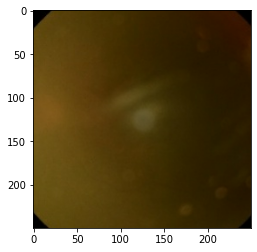

In [18]:
for example in final_train_ds.take(1):
  image, label = example
  break
im, lab = image[13], label[13]
plt.imshow(im.numpy())
print(lab.numpy())

In [23]:
model_cnn = tf.keras.Sequential([
    
    # 1st VGG block
    tf.keras.layers.Conv2D(32, (5, 5), padding = "same", input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(32, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    #2nd VGG block
    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.Conv2D(128, (5, 5), padding = "same"),
    tf.keras.layers.BatchNormalization(center=True, scale=False),
    tf.keras.layers.Activation("relu"),

    tf.keras.layers.MaxPooling2D(pool_size = (3, 3)),
    tf.keras.layers.Dropout(0.45),

    tf.keras.layers.Flatten(),

    tf.keras.layers.Dense(8, activation = 'sigmoid')
])

model_cnn.compile(optimizer=tf.keras.optimizers.Adam(lr=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cnn.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 250, 250, 32)      2432      
_________________________________________________________________
batch_normalization_4 (Batch (None, 250, 250, 32)      96        
_________________________________________________________________
activation_4 (Activation)    (None, 250, 250, 32)      0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 250, 250, 32)      25632     
_________________________________________________________________
batch_normalization_5 (Batch (None, 250, 250, 32)      96        
_________________________________________________________________
activation_5 (Activation)    (None, 250, 250, 32)      0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 83, 83, 32)       

In [0]:
history_cnn = model_cnn.fit(final_train_ds.repeat(),
                    #batch_size=32,
                    epochs=50,
                    steps_per_epoch = 450, #train_elements/batch_size
                    validation_data=final_test_ds.repeat(),
                    validation_steps = 25,
                    use_multiprocessing=True,
                    #class_weight=class_weight
                    )

Epoch 1/50
450/450 [==============================] - 47s 105ms/step - loss: 0.1623 - accuracy: 0.7559 - val_loss: 0.3387 - val_accuracy: 0.4175
Epoch 2/50
450/450 [==============================] - 47s 105ms/step - loss: 0.1603 - accuracy: 0.7572 - val_loss: 0.3414 - val_accuracy: 0.4387
Epoch 3/50
450/450 [==============================] - 47s 105ms/step - loss: 0.1508 - accuracy: 0.7746 - val_loss: 0.3440 - val_accuracy: 0.4400
Epoch 4/50
450/450 [==============================] - 47s 105ms/step - loss: 0.1513 - accuracy: 0.7738 - val_loss: 0.3365 - val_accuracy: 0.4688
Epoch 5/50
450/450 [==============================] - 47s 104ms/step - loss: 0.1443 - accuracy: 0.7869 - val_loss: 0.3919 - val_accuracy: 0.3500
Epoch 6/50
450/450 [==============================] - 46s 103ms/step - loss: 0.1400 - accuracy: 0.7974 - val_loss: 0.3830 - val_accuracy: 0.4225
Epoch 7/50
450/450 [==============================] - 47s 103ms/step - loss: 0.1370 - accuracy: 0.7985 - val_loss: 0.3606 - val_ac

In [29]:
model_cnn.evaluate(train_N_ds, steps=100)
model_cnn.evaluate(train_D_ds, steps=100)
model_cnn.evaluate(train_G_ds, steps=100)
model_cnn.evaluate(train_C_ds, steps=100)
model_cnn.evaluate(train_A_ds, steps=100)
model_cnn.evaluate(train_H_ds, steps=100)
model_cnn.evaluate(train_M_ds, steps=100)
model_cnn.evaluate(train_O_ds, steps=100)
model_cnn.evaluate(train_MIX_ds, steps=100)

100/100 [==============================] - 7s 74ms/step - loss: 0.7983 - accuracy: 0.2491


[0.7982900738716125, 0.24906249344348907]

In [25]:
model_cnn.evaluate(final_test_ds, steps=400)

400/400 [==============================] - 18s 46ms/step - loss: 0.3545 - accuracy: 0.4381


[0.354531854391098, 0.43812501430511475]

In [0]:
model_cnn.save('mdl')

INFO:tensorflow:Assets written to: mdl/assets


In [0]:
!zip -r mdl.zip mdl/

  adding: mdl/ (stored 0%)
  adding: mdl/variables/ (stored 0%)
  adding: mdl/variables/variables.data-00001-of-00002 (deflated 11%)
  adding: mdl/variables/variables.data-00000-of-00002 (deflated 81%)
  adding: mdl/variables/variables.index (deflated 70%)
  adding: mdl/saved_model.pb (deflated 91%)
  adding: mdl/assets/ (stored 0%)


In [0]:
!rm -rf ODIR-5K/Validation_Images